In [1]:
import import_ipynb #Allows you to import ipynb files
from queue import PriorityQueue
from dataclasses import dataclass
import random

from reedsshepp import *
from vehicle import *
from Grid import Grid
from utils import *

importing Jupyter notebook from reedsshepp.ipynb
importing Jupyter notebook from vehicle.ipynb
importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from Grid.ipynb
importing Jupyter notebook from GVD.ipynb


In [2]:
@dataclass
class Cell:
    """The cell is the discretized position that the vehicleState falls into"""
    col: int = -1
    row: int = -1
    ori: float = 0.0
    rev: float = 0.0
    def reset(self):
        self.col = -1
        self.row = -1
        self.ori = 0
        self.rev = 0
    def __eq__(self, other):
        return self.col == other.col and self.row == other.row and self.ori == other.ori

In [3]:
#Node class that the A* will be referencing to check and compare costs
class HybridAStarNode:
    
    def __init__(self, parent=None, cell:Cell=None, vehicleState:VehicleState=None, 
                 rsAction:ReedsSheppAction=None, rspath=None):
        self.cell = cell
        self.vehicleState = vehicleState #Even though cell and vehicle state store the same thing, cell is discrete and vehiclestate is nondiscrete
       
        self.reedsSheppAction = rsAction #recorded as an individual action
        self.rsPath = rspath #is the result if the node was generated used a reedssheeppath
        self.parent = parent
        self.g = 0 #distance to start node
        self.h = 0 #distance to goal node
        
        self.rsindex = -1
    def FCost(self):
        return self.g + self.h
    
    def __eq__(self, other):
        return self.vehicleState == other.vehicleState
    
    def __lt__(self, other):
        return self.FCost() < other.FCost()
    
    def __gt__(self, other):
        return self.FCost() > other.FCost()
    def __repr__(self):
        return 'Point(x=%s, y=%s, ori=%s, rev=%s)' % (self.cell.col, self.cell.row, np.rad2deg(self.cell.ori), self.cell.rev)

In [18]:
#This will implement the basic A* Algorithm
class HybridAStar:
    #class variables
    def __init__(self, grid:Grid, vehicle:Vehicle):
        self._grid = grid
        self._vehicle = vehicle
        self.currentCostMap = [[float('inf') for i in range(self._grid.width)] for j in range(self._grid.height)]
        self.rs = ReedsShepp(self._vehicle)
        
    def ReedsSheppPath(self, current:VehicleState, goal:VehicleState):
        localstart = current.position + (np.rad2deg(current.orientation),)
        localend = goal.position + (np.rad2deg(goal.orientation),)
        
        rspath = self.rs.run_optimalpath(localstart, localend)
        statePath = self.rs.discretizePath(current, rspath, 1, 1)
        safe = True
        for state in statePath:
            if(not (self._grid.IsSafe(state, 1.5) and IsPointInGrid(state.position, (self._grid.width, self._grid.height)))):
                safe = False
                break
        if(safe):
            return HybridAStarNode(vehicleState=goal, rspath=rspath)
        return None
    
    def CalculateRSCost(self, rspath, unit, reverseCost, gearCost):
        length = 0
        for action in rspath:
            if(action.Steer != Steer.Straight):
                length += self._vehicle.turnRadius * action.Length
            else:
                length += action.Length
        if(reverseCost == 1 and gearCost == 0):
            return length * unit
        elif(length == float('inf') or not len(rspath)):
            return float('inf')
        cost = 0
        prevGear = rspath[0].Gear
        for rs in rspath:
            rscost = action.Length * unit
            if(rs.Gear == Gear.Backward):
                rscost *= reverseCost
            if(rs.Gear != prevGear):
                rscost += gearCost
            prevGear = rs.Gear
            cost += rscost
        return cost

    #Generates the Path
    def GeneratePath(self, current):
        path = []
        states = []
        while current is not None:
            if(current.rsPath):
                statePath = self.rs.discretizePath(current.parent.vehicleState, current.rsPath, 1, 1)[::-1]
                for state in statePath:
                    cell = self.statetoCell(state)
                    path.append((cell.row, cell.col))
                    states.append(state)
            else:
                path.append((current.cell.row, current.cell.col))
                states.append(current.vehicleState)
            current = current.parent
        return path[::-1], states[::-1]
    
    #Calculates distance heuristic
    def CalculateDistance(self, current, destination):
        return np.sqrt(((current.vehicleState.position[0] - destination.vehicleState.position[0]) ** 2 + (current.vehicleState.position[1] - destination.vehicleState.position[1]) ** 2))
    
    #gets all neighbors at current node
    def GetNextNodes(self, current_state:VehicleState, gear:Gear, end:VehicleState):
        nodes = []
        for steer in self._vehicle.steers:
            newVehicleState, length = self._vehicle.getNextState(current_state, steer, gear, 1)
            #
            if(IsPointInGrid(newVehicleState.position, (self._grid.width, self._grid.height)) and 
               self._grid.IsSafe(newVehicleState, 1.5)):
                nodes.append(HybridAStarNode(None, None, newVehicleState, ReedsSheppAction(steer, gear, length)))
        #Need to figure out a better way to determine the cost
        cost = np.sqrt(((current_state.position[0] - end.position[0]) ** 2 + (current_state.position[1] - end.position[1]) ** 2))
        if(cost < 10 or random.random() > 10/cost*cost):
            rsNode = self.ReedsSheppPath(current_state, end)
            if(rsNode):
                nodes.append(rsNode)
        return nodes
    
    def statetoCell(self, state:VehicleState):
        x = int(np.floor(state.position[0]))
        y = int(np.floor(state.position[1]))
        theta = mod2Pi(state.orientation)
        rev = 1 if state.gear==Gear.Backward else 0
        return Cell(row=x, col=y, ori=theta, rev=rev)
    
    def run(self, start:VehicleState, end:VehicleState):
        start_node = HybridAStarNode(None, self.statetoCell(start), start, ReedsSheppAction(Steer.Straight, Gear.Forward, 0))
        end_node = HybridAStarNode(None, self.statetoCell(end), end)
        
        open_list = PriorityQueue()
        closed_list = []
        open_list.put(start_node)
        voro = self._grid.returnVoroDistanceMap()
        
        while open_list.qsize():
            current_node = open_list.get()
            closed_list.append(current_node)
            
            if(current_node == end_node):
                return self.GeneratePath(current_node)
            

            for gear in self._vehicle.gears:
                nextNodes = self.GetNextNodes(current_node.vehicleState, gear, end)
                for nextNode in nextNodes:
                    nextNode.parent = current_node
                    nextNode.cell = self.statetoCell(nextNode.vehicleState)
                    v = voro[nextNode.cell.row][nextNode.cell.col]
                    if(nextNode.rsPath):
                        nextNode.g = self.CalculateRSCost(nextNode.rsPath, 1, 1, 1)
                    else:
                        nextNode.g = current_node.g + self.CalculateDistance(current_node, nextNode)*(1+2*v) #path cost
                        
                    nextNode.h = self.CalculateDistance(nextNode, end_node) #hueristic

                    
                    if(nextNode.FCost() < self.currentCostMap[nextNode.cell.col][nextNode.cell.row]):
                        if(nextNode in open_list.queue): continue
                        self.currentCostMap[nextNode.cell.col][nextNode.cell.row] = nextNode.FCost()
                        open_list.put(nextNode)
                        
        print("NO PATH FOUND")
        return self.GeneratePath(start_node)

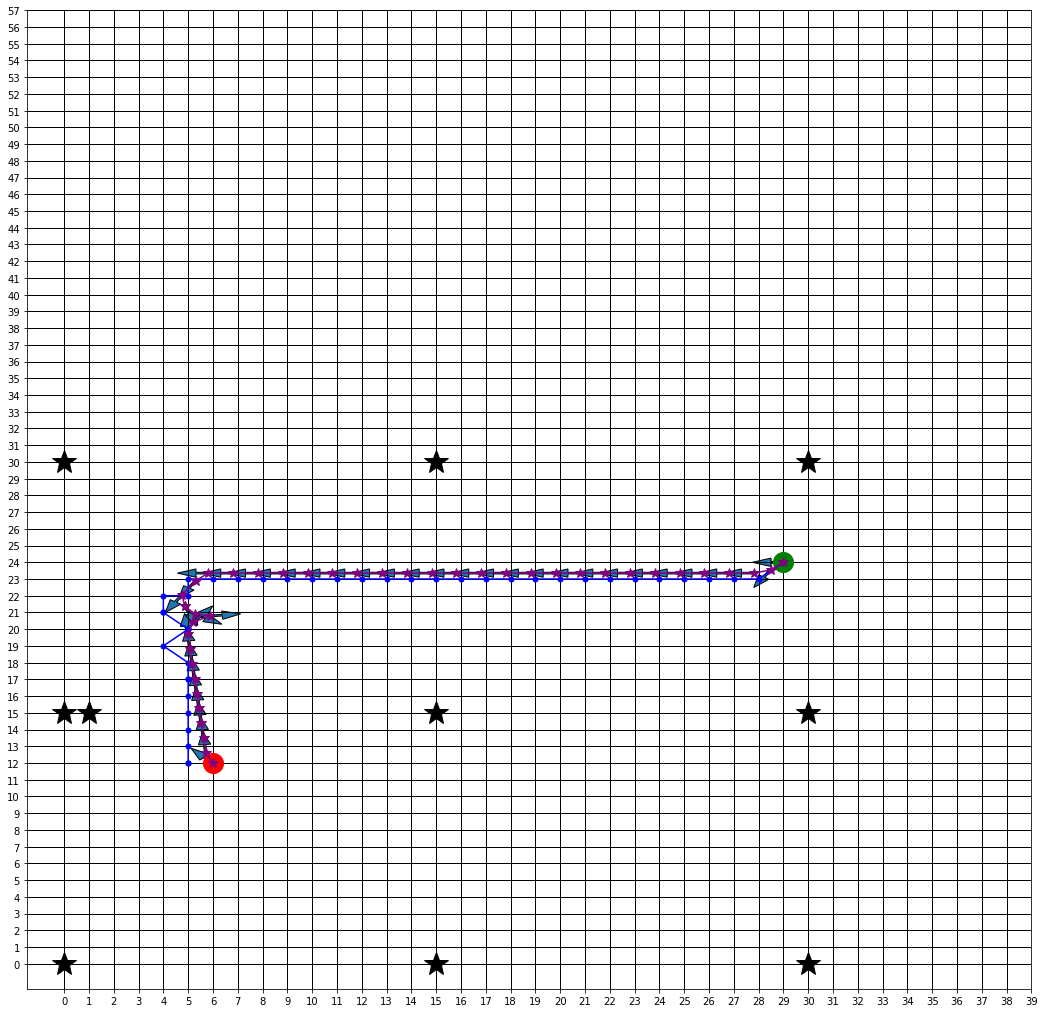

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#x.imshow(data,extent=[0, rows, 0, cols], cmap=cmap, norm=norm)
ax.plot(start.position[0], start.position[1], marker='.', color='green', linestyle='none', MarkerSize=40)
x, y, a, b = start.position[0], start.position[1], 1, np.rad2deg(start.orientation)
x1, y1 = rpoint(x,y,a,b)
plt.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .4, width = .1,color='green')
ax.plot(end.position[0], end.position[1], marker='.', color='red', linestyle='none', MarkerSize=40)
x, y, a, b = end.position[0], end.position[1], 1, np.rad2deg(end.orientation)
x1, y1 = rpoint(x,y,a,b)
plt.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .4, width = .1,color='red')

ax.plot(path_X, path_Y, marker='.', color='blue', MarkerSize=10)
ax.plot(state_X, state_Y, marker='*', color='purple', MarkerSize=10)
ax.plot(obs_X, obs_Y, marker='*', color='black', MarkerSize=25, linestyle='none')
#draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_xticks(np.arange(0, rows, 1))
ax.set_yticks(np.arange(0, cols, 1))
for index in range(len(state_O)):
    x, y, a, b = state_X[index], state_Y[index], 1, np.rad2deg(state_O[index])
    x1, y1 = rpoint(x,y,a,b)
    plt.arrow(x, y, (x1-x)/2, (y1-y)/2, head_width = .5, width = .1,)
    
plt.rcParams['figure.figsize'] = [18, 18]
plt.show()